In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
dataset=pd.read_csv('baseball_salary.csv')
type(dataset)

pandas.core.frame.DataFrame

In [5]:
dataset.head(5)

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,...,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,...,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,...,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,...,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,...,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,...,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [6]:
points = np.array(dataset["打点"])
salary = np.array(dataset["推定年俸"])

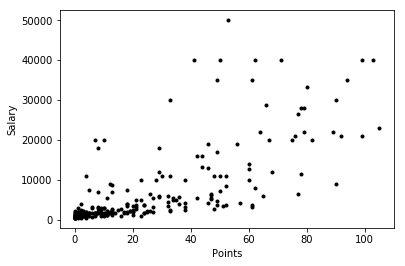

In [8]:
fig = plt.figure()
plt.plot(points, salary, 'k.')
plt.xlabel("Points")
plt.ylabel("Salary")
fig.savefig("images/points_vs_salary_scatter.png")
plt.show()

In [9]:
def distance(a, b, S, P):
    a = np.array(a).reshape((-1,1,1))
    b = np.array(b).reshape((1,-1,1))
    S = S.reshape((1,1,-1))
    P = P.reshape((1,1,-1))
    return ((S - (a*P + b))**2).sum(-1)

In [10]:
a = np.linspace(0, 800, num=400)

In [11]:
b = np.linspace(-10000, 10000, num=250)

In [12]:
D = distance(a, b, salary, points)

In [13]:
A, B = np.meshgrid(a, b, indexing='ij')

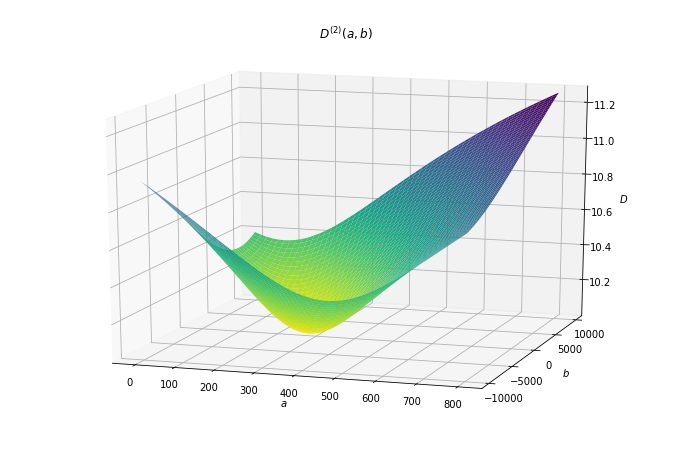

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(12, 8)
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, np.log10(D), cmap=plt.get_cmap("viridis_r"))

ax.set_title("$D^{(2)}(a,b)$")
ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_zlabel("$D$")
ax.set_yticks((-10000, -5000, 0, 5000, 10000))
ax.view_init(azim=-72, elev=15)
fig.savefig("images/linearmodel_paramsweep.png")
plt.show()

In [15]:
def grad2d(fun2d, x, y, delta=1e-8):
    orig = fun2d(x,y)
    gx = (fun2d(x+delta,y) - orig)/delta # f'x
    gy = (fun2d(x,y+delta) - orig)/delta # f'y
    return gx, gy

In [16]:
def least_squares2d(fun2d, p0=(0,0), step=1e-2, gtol=1e-4, ftol=1e-12, max_ev=10**6, log=False, logstep=10000):
    x, y = p0
    v0 = fun2d(x, y)
    v  = v0
    ftol = abs(v0)*ftol
    for i in range(max_ev):
        if log == True and i % logstep == 0:
            print(f"{i:>6d} evaluating: ({x:.4f}, {y:.4f}) ", end='', flush=False)
        gx, gy = grad2d(fun2d, x, y)
        if log == True and i % logstep == 0:
            print(f"(v = {v:.4f}, grad=({gx}, {gy}))", flush=True)
        gnorm = np.linalg.norm([gx, gy])
        if gnorm < gtol:
            # 停止条件1
            print(f"g < gtol satisfied after {i+1} evaluations: {gnorm}")
            return x, y
        # 次の場所を計算
        xnew = x - gx*step/gnorm
        ynew = y - gy*step/gnorm
        vnew = fun2d(xnew, ynew)
        
        dv = vnew - v
        if abs(dv) < ftol:
            # 停止条件2
            print(f"f < ftol satisfied after {i+1} evaluations: {dv}")
            return (xnew, ynew) if dv < 0 else (x, y)
        
        # x, y, vの値を更新
        x = xnew
        y = ynew
        v = vnew
    
    # max_ev回の間に解が見つからなかった
    raise RuntimeError(f"solution not found during {max_ev} evaluations")

In [17]:
def dist(a, b):
    return distance(a, b, salary, points)[0,0]

In [18]:
least_squares2d(dist)

f < ftol satisfied after 50120 evaluations: 0.0250396728515625


(267.48318755951584, 230.89536130581735)

f < ftol satisfied after 50120 evaluations: 0.0250396728515625


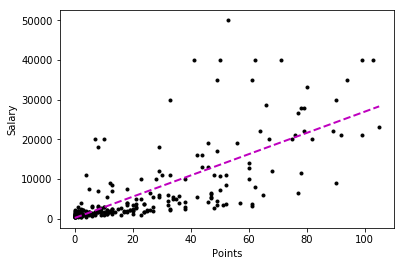

In [19]:
# least_squares2d(dist) の実行結果を a と b に代入する
a, b = least_squares2d(dist)

# 打点をX軸、推定年俸（単位：万円）をY軸にもつ散布図を表示する
fig = plt.figure()
plt.plot(points, salary, 'k.')
plt.xlabel("Points")
plt.ylabel("Salary")

# 線形モデルに対応した直線
pmin = points.min()
pmax = points.max()
plt.plot((pmin, pmax), (a*pmin+b, a*pmax+b), 'm--', lw=2)

# グラフを画像ファイルとして保存しつつ、ここに表示する
fig.savefig("images/linear_regression_plotted.png")
plt.show()

In [20]:
def generate_grad2d(S, P):
    p2 = (P**2).sum()
    p1 = P.sum()
    ps = (P*S).sum()
    s1 = S.sum()
    N  = P.size
    
    def grad2d_exact(a, b):
        gx = 2*(p2*a + p1*b - ps)
        gy = 2*(p1*a + N*b - s1)
        return gx, gy
    
    return grad2d_exact

grad2d_exact = generate_grad2d(salary, points)

In [21]:
def least_squares2d_egrad(p0=(0,0), step=1e-2, gtol=1e-4, ftol=1e-12, max_ev=10**6, log=False, logstep=10000):
    x, y = p0
    v0 = dist(x, y)
    v  = v0
    ftol = abs(v0)*ftol
    for i in range(max_ev):
        if log == True and i % logstep == 0:
            print(f"{i:>6d} evaluating: ({x:.4f}, {y:.4f}) ", end='', flush=False)
        gx, gy = grad2d_exact(x, y)
        if log == True and i % logstep == 0:
            print(f"(v = {v:.4f}, grad=({gx}, {gy}))", flush=True)
        gnorm = np.linalg.norm([gx, gy])
        if gnorm < gtol:
            # 停止条件1
            print(f"g < gtol satisfied after {i+1} evaluations: {gnorm}")
            return x, y
        # 次の場所を計算
        xnew = x - gx*step/gnorm
        ynew = y - gy*step/gnorm
        vnew = dist(xnew, ynew)
        
        dv = vnew - v
        if abs(dv) < ftol:
            # 停止条件2
            print(f"f < ftol satisfied after {i+1} evaluations: {dv}")
            return (xnew, ynew) if dv < 0 else (x, y)
        
        # x, y, vの値を更新
        x = xnew
        y = ynew
        v = vnew
    
    # max_ev回の間に解が見つからなかった
    raise RuntimeError(f"solution not found during {max_ev} evaluations")

In [22]:
least_squares2d_egrad()

f < ftol satisfied after 53089 evaluations: -0.033447265625


(267.3945609523851, 235.05045278758985)

In [23]:
# 確率的勾配降下法で gx と gy を計算する関数
def generate_grad2d_stochastic(S, P):
    
    def grad2d_exact_stochastic(a, b, step, cnt):
        # 配列のindexを作成してシャッフル
        indexes = np.arange(len(P))
        np.random.seed(1)    # ここでは乱数の種を固定しておく
        np.random.shuffle(indexes)
        
        # ひとつひとつのデータから勾配を求める
        for i in indexes:
            pi = P[i]
            si = S[i]
            pisi = pi * si
            pi2 = pi ** 2
            
            ga = 2 * (pi2 * a + pi * b - pisi)
            gb = 2 * (pi * a + b - si)
            v = (si - (a * pi + b)) ** 2
            
            # 次の場所を計算
            a = a - ga / np.sqrt(v) / cnt
            b = b - gb / np.sqrt(v) / cnt
            
        return a, b
    
    return grad2d_exact_stochastic

grad2d_exact_stochastic = generate_grad2d_stochastic(salary, points)

In [24]:
# 確率的勾配降下法を行う関数
def least_squares2d_egrad_stochastic(p0=(0,0), step=1e-2, ftol=1e-12, max_ev=10**6, log=False, logstep=10000):
    x, y = p0
    v0 = dist(x, y)
    v  = v0
    
    ftol = abs(v0)*ftol
    for i in range(max_ev):
        if log == True and i % logstep == 0:
            print(f"{i:>6d} evaluating: ({x:.4f}, {y:.4f}) ", end='', flush=False)
        
        xnew, ynew = grad2d_exact_stochastic(x, y, step, i + 1)
        vnew = ((xnew - x) ** 2 + (ynew - y) ** 2)
        
        dv = np.abs(vnew - v)
        if dv < ftol:
            # 停止条件2
            print(f"f < ftol satisfied after {i+1} evaluations: {dv}")
            return (xnew, ynew) if dv < 0 else (x, y)
        
        # x, y, vの値を更新
        x = xnew
        y = ynew
        v = vnew
    
    # max_ev回の間に解が見つからなかった
    raise RuntimeError(f"solution not found during {max_ev} evaluations")

In [25]:
least_squares2d_egrad_stochastic()

f < ftol satisfied after 55 evaluations: 0.028124567787648047


(213.46296524199258, 317.08013085134627)

In [26]:
def determine_linear(S, P):
    p1 = P.sum()
    p2 = (P**2).sum()
    ps = (P*S).sum()
    s1 = S.sum()
    N  = P.size
    
    A = np.array([[p2,p1],[p1,N]])
    b = np.array([[ps],[s1]])
    a, b = np.dot(np.linalg.inv(A), b)[:,0]
    return a, b

In [27]:
determine_linear(salary, points)

(267.39189411131485, 235.4517787261775)

In [28]:
from scipy.optimize import least_squares
import numpy as np

def linear_regression_base(X, Y):
    """Y = a * X + b となるような(a,b)の最適値を計算する。
    X, Yはいずれも1次元のベクトル型。
    """
    def residuals(x):
        """パラメータx = (a, b)のときの残差を返す"""
        a, b = x
        return Y - (a*X + b)
    
    # residuals()の勾配はどこでも一定なので、ここで定義しておく
    grad = np.stack([-X, -np.ones(X.size, dtype=float)], axis=1)
    
    def gradient(x):
        """パラメータa, bにおけるresiduals()の勾配を返す"""
        return grad
    
    # 初期値
    init = (0, 0)
    
    return least_squares(residuals, init, jac=gradient)

In [29]:
def linear_regression(Y, X):
    """Y = a * X + b の線形モデルをXとYに対してフィットさせ、
    パラメータのタプル(a,b)を返す。
    X, Yはいずれも1次元のベクトル。
    """
    opt = linear_regression_base(X, Y)
    if opt["success"] == False:
        raise RuntimeError("線形モデルのフィッティングに失敗")
    a, b = opt["x"]
    return a, b